In [1]:
from pyspark.sql import SparkSession
import os
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'secrets/serviceKey.json'


# JAR paths for BigQuery and GCS connectors
bigquery_connector_jar = "spark-bigquery-connector.jar"
gcs_connector_jar = "gcs-connector.jar"


# Create SparkSession with both connectors
spark = SparkSession.builder \
    .appName("PySpark with BigQuery and GCS") \
    .config("spark.jars", f"{bigquery_connector_jar},{gcs_connector_jar}") \
    .config("spark.sql.catalog.spark_bigquery", "com.google.cloud.spark.bigquery.BigQueryCatalog") \
    .config("spark.hadoop.google.cloud.auth.service.account.json.keyfile", "secrets/serviceKey.json") \
    .config("spark.bigquery.projectId", "idmpproject-441123") \
    .getOrCreate()

spark

24/12/01 12:53:04 WARN Utils: Your hostname, sabaris-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 10.0.0.198 instead (on interface en0)
24/12/01 12:53:04 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
24/12/01 12:53:04 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [2]:
# Specify the BigQuery table
project_id = "idmpproject-441123"
dataset_id = "uberFareEstimation"
table_name = "uber_data"

bigquery_table = f"{project_id}.{dataset_id}.{table_name}"

# Read data from BigQuery into a Spark DataFrame
uber_df = spark.read \
    .format("bigquery") \
    .option("table", bigquery_table) \
    .load()

# Show the first few rows of the DataFrame
uber_df.show()

+--------+--------+----------------+------------------+-------------+-----+----------------+------+--------+
|distance|cab_type|      time_stamp|       destination|       source|price|surge_multiplier|    id|    name|
+--------+--------+----------------+------------------+-------------+-----+----------------+------+--------+
|    0.94|    Uber|2018-11-28T23:30|         North End|North Station|  4.5|             1.0| 39765|UberPool|
|    0.94|    Uber|2018-12-14T19:30|         North End|North Station|  4.5|             1.0|437984|UberPool|
|    0.63|    Uber|2018-11-27T21:30|Financial District|South Station|  4.5|             1.0|  1644|UberPool|
|    0.63|    Uber|2018-12-15T15:00|Financial District|South Station|  4.5|             1.0| 10780|UberPool|
|    0.63|    Uber|2018-12-15T13:30|Financial District|South Station|  4.5|             1.0| 21598|UberPool|
|    0.63|    Uber|2018-11-28T20:30|Financial District|South Station|  4.5|             1.0| 25567|UberPool|
|    0.63|    Uber|

In [3]:
table_name = "lyft_data"

bigquery_table = f"{project_id}.{dataset_id}.{table_name}"

# Read data from BigQuery into a Spark DataFrame
lyft_df = spark.read \
    .format("bigquery") \
    .option("table", bigquery_table) \
    .load()

# Show the first few rows of the DataFrame
lyft_df.show()

+--------+--------+----------------+------------------+--------------------+-----+----------------+------+------+
|distance|cab_type|      time_stamp|       destination|              source|price|surge_multiplier|    id|  name|
+--------+--------+----------------+------------------+--------------------+-----+----------------+------+------+
|     1.0|    Lyft|2018-12-02T10:30|Financial District|    Haymarket Square|  2.5|             1.0|266234|Shared|
|     1.0|    Lyft|2018-12-02T07:00|         North End|  Financial District|  2.5|             1.0|358706|Shared|
|     1.0|    Lyft|2018-12-17T02:00|Financial District|    Haymarket Square|  2.5|             1.0|401970|Shared|
|     1.0|    Lyft|2018-11-27T00:00|Financial District|    Haymarket Square|  2.5|             1.0|536179|Shared|
|     1.0|    Lyft|2018-12-16T19:00|     North Station|           North End|  2.5|             1.0|572308|Shared|
|    1.25|    Lyft|2018-12-14T09:30|          Back Bay|Northeastern Univ...|  2.5|      

In [4]:
table_name = "weather_data"

bigquery_table = f"{project_id}.{dataset_id}.{table_name}"

# Read data from BigQuery into a Spark DataFrame
weather_df = spark.read \
    .format("bigquery") \
    .option("table", bigquery_table) \
    .load()

# Show the first few rows of the DataFrame
weather_df.show()

+-----+--------------------+------+--------+----+----------------+--------+-----+
| temp|            location|clouds|pressure|rain|      time_stamp|humidity| wind|
+-----+--------------------+------+--------+----+----------------+--------+-----+
|36.26|            West End|   0.0| 1012.37| 0.0|2018-11-29T18:30|    0.69| 6.84|
|29.95|         Beacon Hill|   0.0| 1015.19| 0.0|2018-12-14T18:30|    0.85| 2.43|
|29.85|   Boston University|   0.0|  1015.2| 0.0|2018-11-27T11:30|    0.85| 2.33|
|29.83|              Fenway|   0.0|  1015.2| 0.0|2018-12-16T04:30|    0.85| 2.35|
|29.99|    Haymarket Square|   0.0| 1015.19| 0.0|2018-12-17T06:30|    0.85| 2.46|
|29.95|       North Station|   0.0| 1015.19| 0.0|2018-12-03T22:00|    0.85| 2.44|
|29.88|Northeastern Univ...|   0.0|  1015.2| 0.0|2018-11-27T12:30|    0.85| 2.39|
|29.94|       South Station|   0.0| 1015.19| 0.0|2018-12-04T04:00|    0.85| 2.49|
| 29.9|    Theatre District|   0.0| 1015.19| 0.0|2018-12-17T17:00|    0.85| 2.46|
| 29.9|         

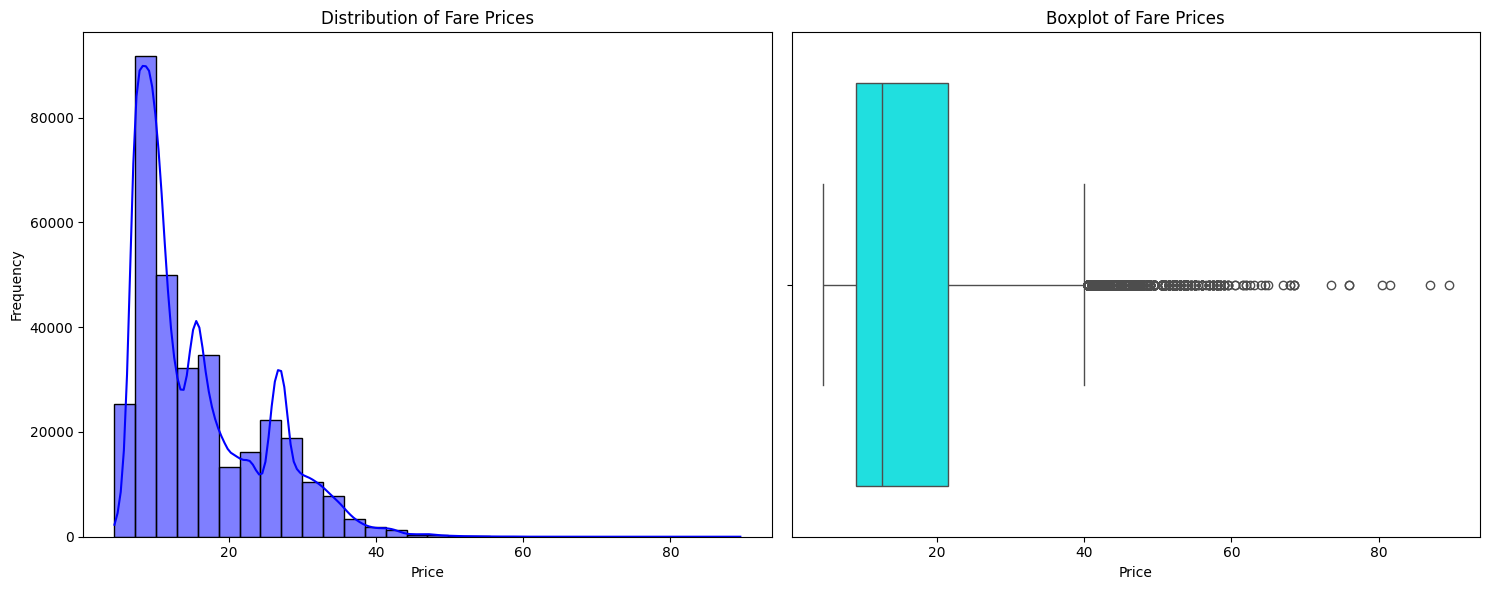

In [5]:
# Visualization 1 Fare price distribution (histogram and bar plot)

from pyspark.sql.functions import col, lit
import matplotlib.pyplot as plt
import seaborn as sns

# Convert the 'price' column to Pandas for visualization
price_data_pd = uber_df.select("price").filter(col("price").isNotNull()).toPandas()

# Create a figure with two subplots: one for the histogram and one for the boxplot
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Histogram Plot
sns.histplot(price_data_pd['price'], bins=30, kde=True, color='blue', ax=axes[0])
axes[0].set_title('Distribution of Fare Prices')
axes[0].set_xlabel('Price')
axes[0].set_ylabel('Frequency')

# Boxplot Plot
sns.boxplot(x=price_data_pd['price'], color='cyan', ax=axes[1])
axes[1].set_title('Boxplot of Fare Prices')
axes[1].set_xlabel('Price')

# Display the plots
plt.tight_layout()
plt.show()

In [6]:
from pyspark.sql import functions as F

# Calculate Q1, Q3, and IQR
quantiles = uber_df.approxQuantile("price", [0.25, 0.75], 0.001)
Q1, Q3 = quantiles[0], quantiles[1]
IQR = Q3 - Q1

# Calculate the upper bound (Q3 + 1.5 * IQR)
upper_bound = Q3 + 1.5 * IQR

# Count the values beyond the upper bound
outliers_count = uber_df.filter(col("price") > upper_bound).count()

# Total number of values
total_count = uber_df.filter(col("price").isNotNull()).count()

# Calculate percentage of outliers
outliers_percentage = (outliers_count / total_count) * 100

# Print the results
print(f"Number of outliers beyond Q3 + 1.5 * IQR: {outliers_count}")
print(f"Percentage of outliers: {outliers_percentage:.2f}%")

Number of outliers beyond Q3 + 1.5 * IQR: 3015
Percentage of outliers: 0.91%


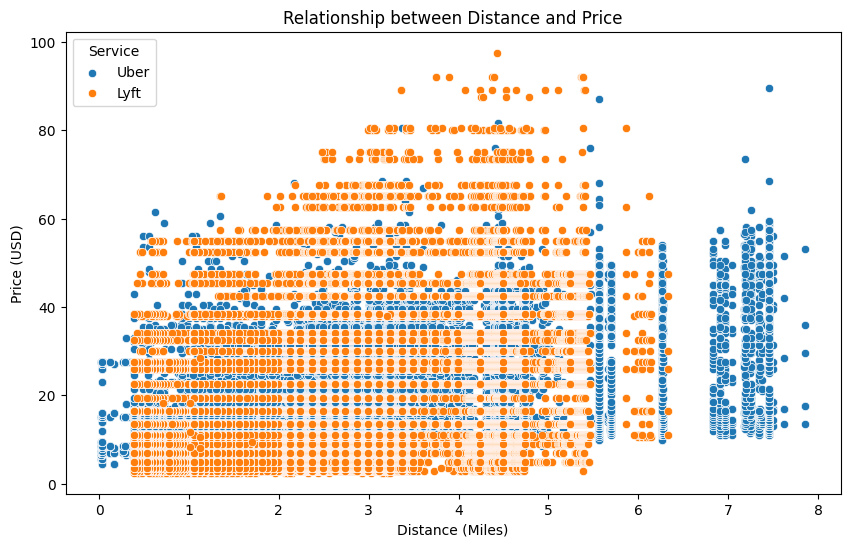

In [7]:
# Visualization 2 Distance vs Price (scatter plot)

distance_price_df_uber = uber_df.select('distance', 'price').toPandas()
distance_price_df_lyft = lyft_df.select('distance', 'price').toPandas()

plt.figure(figsize=(10, 6))

# Scatterplot for Uber with label
sns.scatterplot(x=distance_price_df_uber['distance'], y=distance_price_df_uber['price'], label='Uber')

# Scatterplot for Lyft with label
sns.scatterplot(x=distance_price_df_lyft['distance'], y=distance_price_df_lyft['price'], label='Lyft')

plt.title('Relationship between Distance and Price')
plt.xlabel('Distance (Miles)')
plt.ylabel('Price (USD)')

# Add legend
plt.legend(title='Service')

plt.show()

In [8]:
# Visualization 3 Surge Multiplier Ranges 

from pyspark.sql.functions import min, max

# Calculate minimum and maximum surge_multiplier
min_max_surge = uber_df.select(
    min("surge_multiplier").alias("min_surge"),
    max("surge_multiplier").alias("max_surge")
)

# Show the result
min_max_surge.show()

+---------+---------+
|min_surge|max_surge|
+---------+---------+
|      1.0|      1.0|
+---------+---------+



In [9]:
# Visualization 3 Surge Multiplier Ranges 

from pyspark.sql.functions import min, max

# Calculate minimum and maximum surge_multiplier
min_max_surge = lyft_df.select(
    min("surge_multiplier").alias("min_surge"),
    max("surge_multiplier").alias("max_surge")
)

# Show the result
min_max_surge.show()

+---------+---------+
|min_surge|max_surge|
+---------+---------+
|      1.0|      3.0|
+---------+---------+



In [37]:
# Rename columns in uber_df
uber_df = uber_df.withColumnRenamed("time_stamp", "uber_time_stamp")

# Rename columns in uber_df
lyft_df = lyft_df.withColumnRenamed("time_stamp", "lyft_time_stamp")

# Rename columns in weather_df
weather_df = weather_df.withColumnRenamed("time_stamp", "weather_time_stamp")

In [38]:
from pyspark.sql.functions import coalesce

# Perform the join
uber_joined_df = uber_df.join(
    weather_df,
    (uber_df["uber_time_stamp"] == weather_df["weather_time_stamp"]) & 
    (uber_df["source"] == weather_df["location"]),
    how="left"
)

# Replace missing values in 'location' with the values from 'source'
uber_joined_df = uber_joined_df.withColumn("location", coalesce(uber_joined_df["location"], uber_joined_df["source"]))

# Ensure the DataFrame is sorted by location and timestamp
uber_joined_df = uber_joined_df.orderBy(["location", "uber_time_stamp"])

# Display the result
uber_joined_df.show(5)

+--------+--------+----------------+--------------------+--------+-----+----------------+------+--------+----+--------+------+--------+----+------------------+--------+----+
|distance|cab_type| uber_time_stamp|         destination|  source|price|surge_multiplier|    id|    name|temp|location|clouds|pressure|rain|weather_time_stamp|humidity|wind|
+--------+--------+----------------+--------------------+--------+-----+----------------+------+--------+----+--------+------+--------+----+------------------+--------+----+
|    6.26|    Uber|2018-11-26T03:30|       South Station|Back Bay| 34.0|             1.0|279026|   Black|NULL|Back Bay|  NULL|    NULL|NULL|              NULL|    NULL|NULL|
|    1.34|    Uber|2018-11-26T04:30|              Fenway|Back Bay|  9.0|             1.0| 74133|     WAV|NULL|Back Bay|  NULL|    NULL|NULL|              NULL|    NULL|NULL|
|    1.08|    Uber|2018-11-26T04:30|Northeastern Univ...|Back Bay|  7.5|             1.0|150814|     WAV|NULL|Back Bay|  NULL|    

In [39]:
from pyspark.sql.window import Window
from pyspark.sql.functions import col, last, first, when, lit, coalesce

# Ensure the DataFrame is sorted by location and timestamp
uber_joined_df = uber_joined_df.orderBy(["location", "uber_time_stamp"])

# List of weather columns to fill
weather_columns = ['temp', 'clouds', 'pressure', 'rain', 'humidity', 'wind']

# Create a helper column for weather source timestamp
uber_joined_df = uber_joined_df.withColumn("weather_source_timestamp", col("uber_time_stamp"))

# Define a window partitioned by location and ordered by timestamp
window_spec = Window.partitionBy("location").orderBy("uber_time_stamp")

# Fill weather columns using forward and backward filling
for col_name in weather_columns:
    # Forward fill
    forward_filled = last(col(col_name), ignorenulls=True).over(window_spec)
    # Backward fill
    backward_filled = first(col(col_name), ignorenulls=True).over(window_spec.rowsBetween(Window.unboundedPreceding, Window.unboundedFollowing))
    
    # Update the column: only fill the null values (preserve non-null values)
    uber_joined_df = uber_joined_df.withColumn(
        col_name,
        when(col(col_name).isNull(), coalesce(forward_filled, backward_filled)).otherwise(col(col_name))
    )

# Propagate the weather source timestamp
uber_joined_df = uber_joined_df.withColumn(
    "weather_source_timestamp",
    when(col("weather_source_timestamp").isNull(), last("weather_source_timestamp", ignorenulls=True).over(window_spec)).otherwise(col("weather_source_timestamp"))
)

# Display the result
uber_joined_df.show(5)

+--------+--------+----------------+--------------------+------------------+-----+----------------+------+--------+-----+------------------+------+--------+----+------------------+--------+----+------------------------+
|distance|cab_type| uber_time_stamp|         destination|            source|price|surge_multiplier|    id|    name| temp|          location|clouds|pressure|rain|weather_time_stamp|humidity|wind|weather_source_timestamp|
+--------+--------+----------------+--------------------+------------------+-----+----------------+------+--------+-----+------------------+------+--------+----+------------------+--------+----+------------------------+
|    0.39|    Uber|2018-11-26T04:30|       South Station|Financial District|  7.0|             1.0| 45533|     WAV|41.14|Financial District|  0.93| 1000.16| 0.0|              NULL|    0.78|7.58|        2018-11-26T04:30|
|    0.39|    Uber|2018-11-26T04:30|       South Station|Financial District|  7.0|             1.0| 98310|     WAV|41.14

In [40]:
from pyspark.sql.functions import coalesce, col

# Step 1: Replace 'weather_time_stamp' with 'weather_source_timestamp' where available
uber_joined_df = uber_joined_df.withColumn(
    "weather_time_stamp",
    coalesce(col("weather_source_timestamp"), col("weather_time_stamp"))
)

# Step 2: Remove 'weather_source_timestamp' column
uber_joined_df = uber_joined_df.drop("weather_source_timestamp")

# Step 3: Count rows with any null value
rows_before = uber_joined_df.count()
uber_joined_df = uber_joined_df.na.drop()  # Remove rows with any null values
rows_after = uber_joined_df.count()

# Step 4: Print the number of rows removed
rows_removed = rows_before - rows_after
print(f"Number of rows removed: {rows_removed}")

Number of rows removed: 0


In [41]:
row_count = uber_joined_df.count()
print(f"Number of rows in uber_joined_df: {row_count}")

Number of rows in uber_joined_df: 330568


In [42]:
uber_joined_df.show()

+--------+--------+----------------+--------------------+------------------+-----+----------------+------+---------+-----+------------------+------+--------+----+------------------+--------+----+
|distance|cab_type| uber_time_stamp|         destination|            source|price|surge_multiplier|    id|     name| temp|          location|clouds|pressure|rain|weather_time_stamp|humidity|wind|
+--------+--------+----------------+--------------------+------------------+-----+----------------+------+---------+-----+------------------+------+--------+----+------------------+--------+----+
|    0.39|    Uber|2018-11-26T04:30|       South Station|Financial District|  7.0|             1.0| 45533|      WAV|41.14|Financial District|  0.93| 1000.16| 0.0|  2018-11-26T04:30|    0.78|7.58|
|    0.39|    Uber|2018-11-26T04:30|       South Station|Financial District|  7.0|             1.0| 98310|      WAV|41.14|Financial District|  0.93| 1000.16| 0.0|  2018-11-26T04:30|    0.78|7.58|
|    1.25|    Uber|2

Correlation between temp and price: 0.0024826472607068903


Correlation between clouds and price: 0.0026027548056761197


Correlation between pressure and price: 0.0007553580687251905


Correlation between rain and price: -0.005079315489030763


Correlation between humidity and price: 0.0006277214839144511


Correlation between wind and price: -0.0031424299009538996


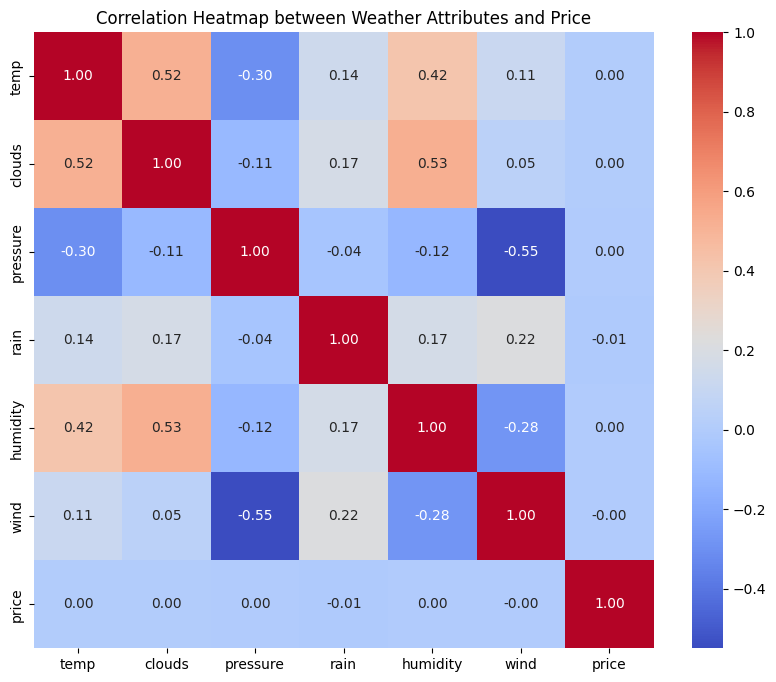

In [43]:
from pyspark.sql.functions import col
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Step 1: Select relevant columns
weather_columns = ['temp', 'clouds', 'pressure', 'rain', 'humidity', 'wind']
target_column = 'price'
selected_columns = weather_columns + [target_column]
selected_df = uber_joined_df.select(*selected_columns)

# Step 2: Compute correlations in PySpark
correlations = {}
for column in weather_columns:
    corr_value = selected_df.stat.corr(column, target_column)
    correlations[column] = corr_value
    print(f"Correlation between {column} and {target_column}: {corr_value}")

# Step 3: Convert to Pandas for visualization
selected_pandas_df = selected_df.toPandas()

# Compute the correlation matrix
correlation_matrix = selected_pandas_df.corr()

# Step 4: Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap between Weather Attributes and Price")
plt.show()

In [45]:
from pyspark.sql.functions import coalesce

# Perform the join
lyft_joined_df = lyft_df.join(
    weather_df,
    (lyft_df["lyft_time_stamp"] == weather_df["weather_time_stamp"]) & 
    (lyft_df["source"] == weather_df["location"]),
    how="left"
)

# Replace missing values in 'location' with the values from 'source'
lyft_joined_df = lyft_joined_df.withColumn("location", coalesce(lyft_joined_df["location"], lyft_joined_df["source"]))

# Ensure the DataFrame is sorted by location and timestamp
lyft_joined_df = lyft_joined_df.orderBy(["location", "lyft_time_stamp"])

# Display the result
lyft_joined_df.show(5)

+--------+--------+----------------+----------------+--------+-----+----------------+------+------------+----+--------+------+--------+----+------------------+--------+----+
|distance|cab_type| lyft_time_stamp|     destination|  source|price|surge_multiplier|    id|        name|temp|location|clouds|pressure|rain|weather_time_stamp|humidity|wind|
+--------+--------+----------------+----------------+--------+-----+----------------+------+------------+----+--------+------+--------+----+------------------+--------+----+
|    2.31|    Lyft|2018-11-26T03:30|Haymarket Square|Back Bay|  3.0|             1.0|167627|      Shared|NULL|Back Bay|  NULL|    NULL|NULL|              NULL|    NULL|NULL|
|    1.66|    Lyft|2018-11-26T03:30|          Fenway|Back Bay| 26.0|            1.75| 98899|         Lux|NULL|Back Bay|  NULL|    NULL|NULL|              NULL|    NULL|NULL|
|    2.31|    Lyft|2018-11-26T03:30|Haymarket Square|Back Bay| 10.5|             1.0|167628|        Lyft|NULL|Back Bay|  NULL|    

In [46]:
from pyspark.sql.window import Window
from pyspark.sql.functions import col, last, first, when, lit, coalesce

# Ensure the DataFrame is sorted by location and timestamp
lyft_joined_df = lyft_joined_df.orderBy(["location", "lyft_time_stamp"])

# List of weather columns to fill
weather_columns = ['temp', 'clouds', 'pressure', 'rain', 'humidity', 'wind']

# Create a helper column for weather source timestamp
lyft_joined_df = lyft_joined_df.withColumn("weather_source_timestamp", col("lyft_time_stamp"))

# Define a window partitioned by location and ordered by timestamp
window_spec = Window.partitionBy("location").orderBy("lyft_time_stamp")

# Fill weather columns using forward and backward filling
for col_name in weather_columns:
    # Forward fill
    forward_filled = last(col(col_name), ignorenulls=True).over(window_spec)
    # Backward fill
    backward_filled = first(col(col_name), ignorenulls=True).over(window_spec.rowsBetween(Window.unboundedPreceding, Window.unboundedFollowing))
    
    # Update the column: only fill the null values (preserve non-null values)
    lyft_joined_df = lyft_joined_df.withColumn(
        col_name,
        when(col(col_name).isNull(), coalesce(forward_filled, backward_filled)).otherwise(col(col_name))
    )

# Propagate the weather source timestamp
lyft_joined_df = lyft_joined_df.withColumn(
    "weather_source_timestamp",
    when(col("weather_source_timestamp").isNull(), last("weather_source_timestamp", ignorenulls=True).over(window_spec)).otherwise(col("weather_source_timestamp"))
)

# Display the result
lyft_joined_df.show(5)

+--------+--------+----------------+--------------------+------------------+-----+----------------+------+------------+-----+------------------+------+--------+----+------------------+--------+----+------------------------+
|distance|cab_type| lyft_time_stamp|         destination|            source|price|surge_multiplier|    id|        name| temp|          location|clouds|pressure|rain|weather_time_stamp|humidity|wind|weather_source_timestamp|
+--------+--------+----------------+--------------------+------------------+-----+----------------+------+------------+-----+------------------+------+--------+----+------------------+--------+----+------------------------+
|    4.52|    Lyft|2018-11-26T03:30|              Fenway|Financial District| 13.5|             1.0|369166|        Lyft|46.88|Financial District|  0.91| 1021.45| 0.0|              NULL|    0.87| 5.9|        2018-11-26T03:30|
|    4.52|    Lyft|2018-11-26T03:30|              Fenway|Financial District| 32.5|             1.0|36916

In [47]:
from pyspark.sql.functions import coalesce, col

# Step 1: Replace 'weather_time_stamp' with 'weather_source_timestamp' where available
lyft_joined_df = lyft_joined_df.withColumn(
    "weather_time_stamp",
    coalesce(col("weather_source_timestamp"), col("weather_time_stamp"))
)

# Step 2: Remove 'weather_source_timestamp' column
lyft_joined_df = lyft_joined_df.drop("weather_source_timestamp")

# Step 3: Count rows with any null value
rows_before = lyft_joined_df.count()
lyft_joined_df = lyft_joined_df.na.drop()  # Remove rows with any null values
rows_after = lyft_joined_df.count()

# Step 4: Print the number of rows removed
rows_removed = rows_before - rows_after
print(f"Number of rows removed: {rows_removed}")

Number of rows removed: 0


In [48]:
row_count = lyft_joined_df.count()
print(f"Number of rows in lyft_joined_df: {row_count}")

Number of rows in lyft_joined_df: 307408


In [49]:
lyft_joined_df.show()

+--------+--------+----------------+--------------------+------------------+-----+----------------+------+------------+-----+------------------+------+--------+----+------------------+--------+----+
|distance|cab_type| lyft_time_stamp|         destination|            source|price|surge_multiplier|    id|        name| temp|          location|clouds|pressure|rain|weather_time_stamp|humidity|wind|
+--------+--------+----------------+--------------------+------------------+-----+----------------+------+------------+-----+------------------+------+--------+----+------------------+--------+----+
|    4.52|    Lyft|2018-11-26T03:30|              Fenway|Financial District| 13.5|             1.0|369166|        Lyft|46.88|Financial District|  0.91| 1021.45| 0.0|  2018-11-26T03:30|    0.87| 5.9|
|    4.52|    Lyft|2018-11-26T03:30|              Fenway|Financial District| 32.5|             1.0|369168|   Lux Black|46.88|Financial District|  0.91| 1021.45| 0.0|  2018-11-26T03:30|    0.87| 5.9|
|    

Correlation between temp and price: 4.612784059698057e-05


Correlation between clouds and price: -0.0026280153036614966


Correlation between pressure and price: 0.0013729275365591646


Correlation between rain and price: -0.0035505649972182403


Correlation between humidity and price: 0.001629748191255186


Correlation between wind and price: -0.003549531697225524


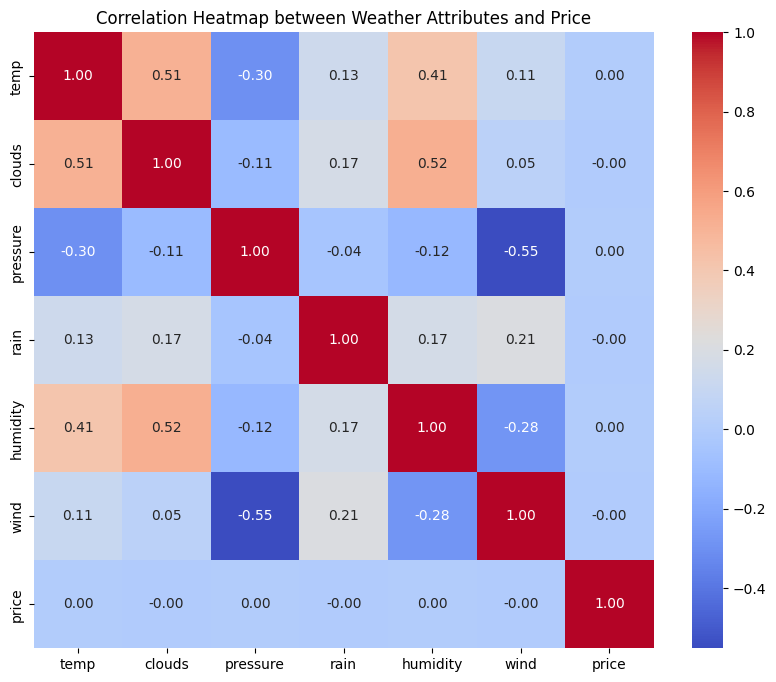

In [50]:
from pyspark.sql.functions import col
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Step 1: Select relevant columns
weather_columns = ['temp', 'clouds', 'pressure', 'rain', 'humidity', 'wind']
target_column = 'price'
selected_columns = weather_columns + [target_column]
selected_df = lyft_joined_df.select(*selected_columns)

# Step 2: Compute correlations in PySpark
correlations = {}
for column in weather_columns:
    corr_value = selected_df.stat.corr(column, target_column)
    correlations[column] = corr_value
    print(f"Correlation between {column} and {target_column}: {corr_value}")

# Step 3: Convert to Pandas for visualization
selected_pandas_df = selected_df.toPandas()

# Compute the correlation matrix
correlation_matrix = selected_pandas_df.corr()

# Step 4: Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap between Weather Attributes and Price")
plt.show()

Metrics Summary:
Condition: No Rain, Average Price: 15.81, Number of Trips: 286721, 
Condition: Rain, Average Price: 15.70, Number of Trips: 43847, 


/var/folders/p5/x75z801n01z15xp10rx4v9q00000gn/T/ipykernel_45975/455755447.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rain_labels, y=avg_prices, palette="Set2", ax=ax1)


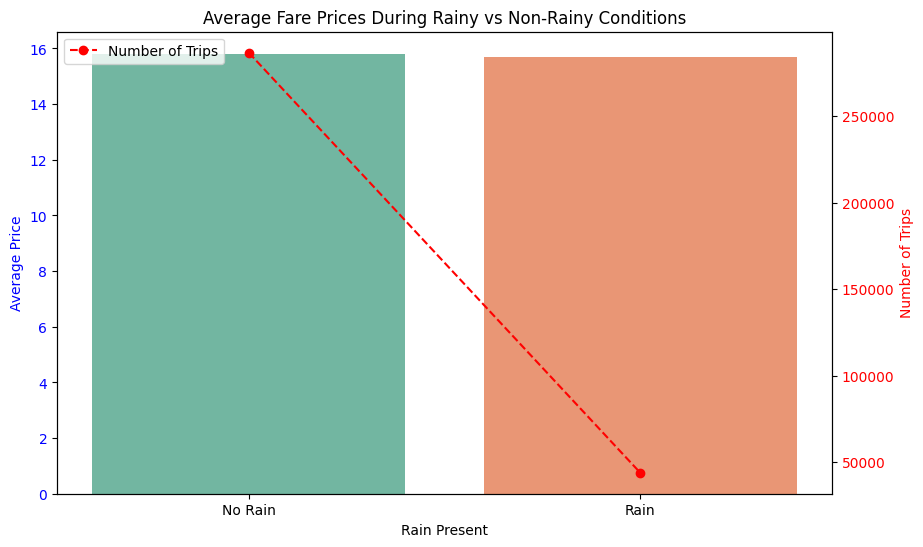

In [53]:
from pyspark.sql.functions import when, col, avg, count, sum

# Add a column to indicate rain presence (True for rain > 0, False otherwise)
uber_joined_df = uber_joined_df.withColumn("rain_present", when(col("rain") > 0, "Rain").otherwise("No Rain"))

# Calculate metrics: average price, number of rain days, number of trips booked
metrics_df = (
    uber_joined_df.groupBy("rain_present")
    .agg(
        avg("price").alias("avg_price"),
        count("rain_present").alias("number_of_trips"),
    )
)

# Collect the results for display
metrics_data = metrics_df.collect()

# Print the numerical metrics
print("Metrics Summary:")
for row in metrics_data:
    print(
        f"Condition: {row['rain_present']}, "
        f"Average Price: {row['avg_price']:.2f}, "
        f"Number of Trips: {row['number_of_trips']}, "
    )

# Prepare data for visualization
rain_labels = [row["rain_present"] for row in metrics_data]
avg_prices = [row["avg_price"] for row in metrics_data]
number_of_trips = [row["number_of_trips"] for row in metrics_data]

# Create the graph
fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar plot for average prices
sns.barplot(x=rain_labels, y=avg_prices, palette="Set2", ax=ax1)
ax1.set_title("Average Fare Prices During Rainy vs Non-Rainy Conditions")
ax1.set_xlabel("Rain Present")
ax1.set_ylabel("Average Price", color="b")
ax1.tick_params(axis="y", labelcolor="b")

# Line plot for number of trips
ax2 = ax1.twinx()
ax2.plot(rain_labels, number_of_trips, color="r", marker="o", linestyle="--", label="Number of Trips")
ax2.set_ylabel("Number of Trips", color="r")
ax2.tick_params(axis="y", labelcolor="r")

# Add legend and show the plot
ax2.legend(loc="upper left")
plt.show()

Metrics Summary:
Condition: No Rain, Average Price: 17.36, Number of Trips: 267053, 
Condition: Rain, Average Price: 17.26, Number of Trips: 40355, 


/var/folders/p5/x75z801n01z15xp10rx4v9q00000gn/T/ipykernel_45975/2779240006.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rain_labels, y=avg_prices, palette="Set2", ax=ax1)


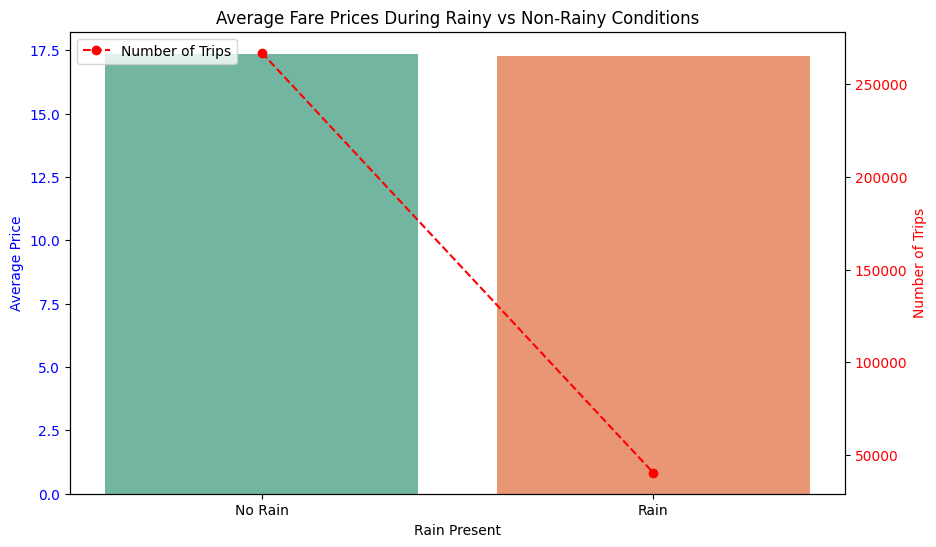

In [57]:
from pyspark.sql.functions import when, col, avg, count, sum

# Add a column to indicate rain presence (True for rain > 0, False otherwise)
lyft_joined_df = lyft_joined_df.withColumn("rain_present", when(col("rain") > 0, "Rain").otherwise("No Rain"))

# Calculate metrics: average price, number of rain days, number of trips booked
metrics_df = (
    lyft_joined_df.groupBy("rain_present")
    .agg(
        avg("price").alias("avg_price"),
        count("rain_present").alias("number_of_trips"),
    )
)

# Collect the results for display
metrics_data = metrics_df.collect()

# Print the numerical metrics
print("Metrics Summary:")
for row in metrics_data:
    print(
        f"Condition: {row['rain_present']}, "
        f"Average Price: {row['avg_price']:.2f}, "
        f"Number of Trips: {row['number_of_trips']}, "
    )

# Prepare data for visualization
rain_labels = [row["rain_present"] for row in metrics_data]
avg_prices = [row["avg_price"] for row in metrics_data]
number_of_trips = [row["number_of_trips"] for row in metrics_data]

# Create the graph
fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar plot for average prices
sns.barplot(x=rain_labels, y=avg_prices, palette="Set2", ax=ax1)
ax1.set_title("Average Fare Prices During Rainy vs Non-Rainy Conditions")
ax1.set_xlabel("Rain Present")
ax1.set_ylabel("Average Price", color="b")
ax1.tick_params(axis="y", labelcolor="b")

# Line plot for number of trips
ax2 = ax1.twinx()
ax2.plot(rain_labels, number_of_trips, color="r", marker="o", linestyle="--", label="Number of Trips")
ax2.set_ylabel("Number of Trips", color="r")
ax2.tick_params(axis="y", labelcolor="r")

# Add legend and show the plot
ax2.legend(loc="upper left")
plt.show()

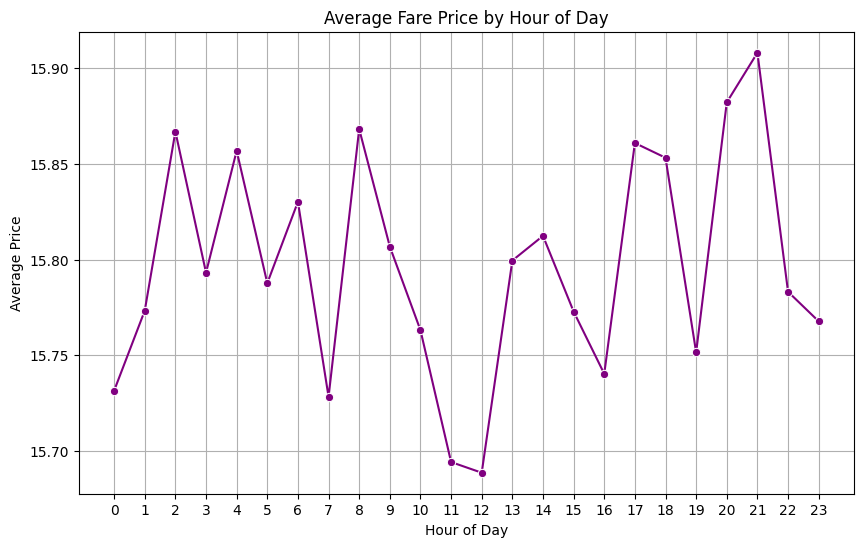

In [58]:
from pyspark.sql.functions import col, hour, avg
import matplotlib.pyplot as plt
import seaborn as sns

# Create a new DataFrame for time processing without modifying the original
time_processed_df = uber_joined_df.select(
    col("uber_time_stamp").cast("timestamp").alias("time"),
    col("price")
).withColumn("hour", hour(col("time")))

# Group by hour and calculate the average price
avg_price_by_hour = (
    time_processed_df.groupBy("hour")
    .agg(avg("price").alias("avg_price"))
    .orderBy("hour")
)

# Collect results into a Pandas DataFrame for plotting
avg_price_by_hour_pd = avg_price_by_hour.toPandas()

# Plot using matplotlib and seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(data=avg_price_by_hour_pd, x="hour", y="avg_price", marker="o", color="purple")
plt.title("Average Fare Price by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Average Price")
plt.xticks(range(0, 24))
plt.grid()
plt.show()

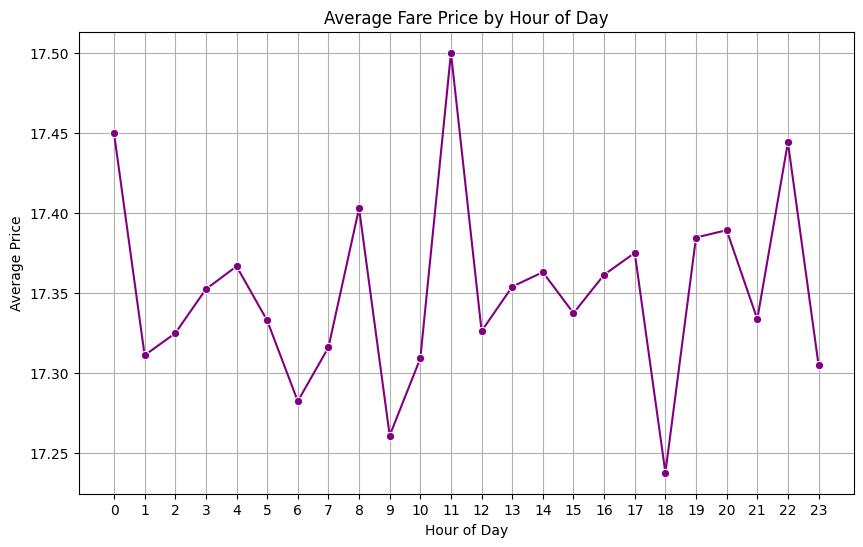

In [61]:
from pyspark.sql.functions import col, hour, avg
import matplotlib.pyplot as plt
import seaborn as sns

# Create a new DataFrame for time processing without modifying the original
time_processed_df = lyft_joined_df.select(
    col("lyft_time_stamp").cast("timestamp").alias("time"),
    col("price")
).withColumn("hour", hour(col("time")))

# Group by hour and calculate the average price
avg_price_by_hour = (
    time_processed_df.groupBy("hour")
    .agg(avg("price").alias("avg_price"))
    .orderBy("hour")
)

# Collect results into a Pandas DataFrame for plotting
avg_price_by_hour_pd = avg_price_by_hour.toPandas()

# Plot using matplotlib and seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(data=avg_price_by_hour_pd, x="hour", y="avg_price", marker="o", color="purple")
plt.title("Average Fare Price by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Average Price")
plt.xticks(range(0, 24))
plt.grid()
plt.show()